# Gradient Boosting Classifier
* Gradient Boosting combines the strengths of multiple weak learners (typically Decision Trees) to create a stronger predictive model. It takes a sequential, additive approach to correct the errors of previous models and improves the accuracy. The following is how Gradient Boosting works:
    1. Take a shallow decision tree and train it on the data
    2. Make prediction using this weak learner
    3. Assign weights to data points based on the magnitude of pseudo-residuals ($r_i = y_i - p_i$ where $r_i$ is the ith residual, $y_i$ is the class label of the ith data point, and $p_i$ is the predicted probability of that class for the ith data point)
    4. Another weak learner is fitted on this weighted data, focusing more on points that were poorly predicted
    5. Repeat 3-4 until stopping criteria is met
    6. Final predictions is generated using a weighted average of all the weak learners - weights are usually determined by the performance of each weak learner on the training data and pseudo-residuals

In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import pickle
import sqlite3

## Split the Data into Training and Testing Sets

In [12]:
# Load the test data into a Pandas DataFrame
df_test = pd.read_csv("https://machine-failure-data-20230822-craiguo.s3.us-west-2.amazonaws.com/test.csv")

# Store the id's for later use
id_numbers = df_test['id'].tolist()

# Drop columns not needed for training
df_test.drop(columns=['id', 'Product ID'], inplace=True)

# Display sample data
df_test.head(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
5,L,299.1,308.3,1489,38.2,139,0,0,0,0,0
6,L,299.8,309.1,1429,39.9,207,0,0,0,0,0
7,L,302.7,312.4,1540,46.2,17,0,0,0,0,0
8,H,300.7,311.9,1613,36.0,12,0,0,0,0,0
9,L,300.5,311.4,1708,32.2,57,0,0,0,0,0


In [13]:
# Load the test data into a Pandas DataFrame
df_train = pd.read_csv("https://machine-failure-data-20230822-craiguo.s3.us-west-2.amazonaws.com/train.csv")
df_train.drop(columns=['id', 'Product ID'], inplace=True)

# Display sample data
df_train.head(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
5,M,298.4,308.9,1429,42.1,65,0,0,0,0,0,0
6,L,299.6,311.0,1413,42.9,156,0,0,0,0,0,0
7,L,298.7,310.1,1609,38.1,67,0,0,0,0,0,0
8,L,297.7,308.8,1578,35.2,13,0,0,0,0,0,0
9,L,300.5,312.3,1447,53.3,98,0,0,0,0,0,0


In [14]:
# Look at nunique counts for train
df_train.nunique()

Type                         3
Air temperature [K]         95
Process temperature [K]     81
Rotational speed [rpm]     952
Torque [Nm]                611
Tool wear [min]            246
Machine failure              2
TWF                          2
HDF                          2
PWF                          2
OSF                          2
RNF                          2
dtype: int64

In [15]:
# Look at nunique counts for test
df_test.nunique()

Type                         3
Air temperature [K]         92
Process temperature [K]     84
Rotational speed [rpm]     946
Torque [Nm]                595
Tool wear [min]            246
TWF                          2
HDF                          2
PWF                          2
OSF                          2
RNF                          2
dtype: int64

In [16]:
# concatenate the dataframes to use pd.get_dummies() on 'Product ID' and 'Type'

combined_df = pd.concat([df_train, df_test], sort=False)
combined_df.tail()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
90949,L,302.3,311.4,1484,40.4,15,NaN,0,0,0,0,0
90950,L,297.9,309.8,1542,33.8,31,NaN,0,0,0,0,0
90951,L,295.6,306.2,1501,41.4,187,NaN,0,0,0,0,0
90952,L,298.1,307.8,1534,40.3,69,NaN,0,0,0,0,0
90953,L,303.5,312.8,1534,36.1,92,NaN,0,0,0,0,0


In [17]:
# Save the original data and the pre-processed data into a database
# Open the database file
conn = sqlite3.connect('../../Data/machine_failure.db')

df_train.to_sql('machine_failure_train', conn, index=False, if_exists='replace')
df_test.to_sql('machine_failure_test', conn, index=False, if_exists='replace')
combined_df.to_sql('machine_failure_combined', conn, index=False, if_exists='replace')

227383

In [7]:
#use pd.get_dummies() for 'Type' and split test and train sets again

dummies_df = pd.get_dummies(combined_df)

col = df_train.shape[0]

dummy_train = dummies_df.iloc[0:col]
dummy_test = dummies_df.iloc[col:]

### Step 2: Create features and target arrays

In [8]:
# Split our preprocessed data into our features and target arrays

y = dummy_train['Machine failure']
X = dummy_train.drop(columns = 'Machine failure')

In [9]:
oversample = RandomOverSampler(random_state=1, sampling_strategy=1)
X, y = oversample.fit_resample(X, y)

In [10]:
# Review the y variable Series
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Machine failure, dtype: float64

In [11]:
# Review the X variable DataFrame
X.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,1,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,1
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,1,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,1,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,0,1


### Step 3: Split the data into training and testing datasets by using `train_test_split`.

In [12]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

# Create a Gradient Boosting Regressor
model = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_gb = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Best Estimators: {best_gb.n_estimators}")
print(f"Best Learning Rate: {best_gb.learning_rate}")
print(f"Best Max Depth: {best_gb.max_depth}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

In [ ]:
# Save model to file
model_gboost = "Models/model_gboost_best.pkl"
with open (model_gboost, "wb") as filename: 
    pickle.dump(best_gb, filename)

In [14]:
# Load model from file
model_gboost = "Models/model_gboost_best.pkl"
with open(model_gboost, "rb") as filename:
    model = pickle.load(filename)

In [15]:
importance = model.feature_importances_
for value in importance:
    print(value)

0.027942016669559856
0.016152054051691855
0.3928442442783027
0.11232606281766182
0.12537209944349717
0.06569342295362093
0.05739014399543155
0.10772088181075569
0.09123989736585074
3.562642918080847e-05
0.0017161127056661868
0.0006631711398412334
0.0009042663389394686


In [41]:
# Make a DataFrame with features importance with labels, for plotting
features_importance_df = pd.DataFrame({"Feature Importance": importance, "Feature": X.columns})
features_importance_df = features_importance_df.sort_values(by="Feature Importance", ascending=False)
features_importance_df

,Feature Importance,Feature
2,0.392844,Rotational speed [rpm]
4,0.125372,Tool wear [min]
3,0.112326,Torque [Nm]
7,0.107721,PWF
8,0.091240,OSF
5,0.065693,TWF
6,0.057390,HDF
0,0.027942,Air temperature [K]
1,0.016152,Process temperature [K]
10,0.001716,Type_H


<BarContainer object of 13 artists>

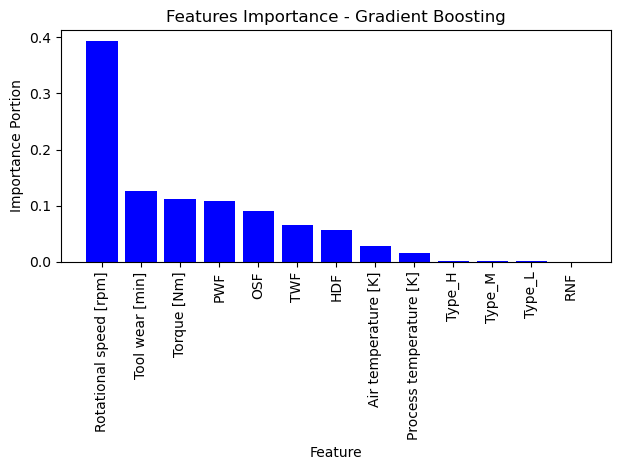

In [43]:
# Create a bar chart based upon the feature importances data
x_axis = np.arange(len(features_importance_df["Feature Importance"]))
fig1 = plt.bar(x_axis, features_importance_df["Feature Importance"], color="b", align="center")
plt.title("Features Importance - Gradient Boosting")
plt.xlabel("Feature")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, features_importance_df["Feature"], rotation="vertical")
plt.ylabel("Importance Portion")

# Save our graph and show the graph
plt.tight_layout()
plt.savefig("features_importance_gboost_best.png")
fig1

In [ ]:
# Review test data
dummy_test.head()

In [ ]:
# Drop target column from the validation set so it matches training input
val_set = dummy_test.drop(columns = 'Machine failure')

# Use the best model from the grid search to predict values for the validation set
val_predict = best_gb.predict(val_set)

# Review the results
val_predict

In [ ]:
# Compiling predictions into a dataframe
submission_df = pd.DataFrame({"id": id_numbers, "Machine failure": val_predict})
submission_df.head()

In [ ]:
# Saving predictions into a csv for submission to Kaggle
submission_df.to_csv("Kaggle_Submissions/gradboost_prediction_submission_9.csv", index=False)